In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
 
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

In [2]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
 
# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
 
# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
 
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

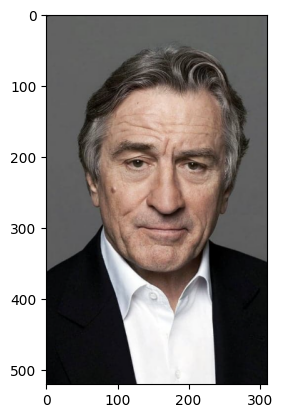

In [9]:
# load the image
image = cv2.imread(r"../fatigue_detection/images/test-open-eyes.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.ascontiguousarray(image)
imgH, imgW, _ = image.shape
plt.imshow(image)

In [10]:
# Running inference using static_image_mode 
with mp_facemesh.FaceMesh(
    static_image_mode=True,         # Default=False
    max_num_faces=1,                # Default=1
    refine_landmarks=False,         # Default=False
    min_detection_confidence=0.5,   # Default=0.5
    min_tracking_confidence= 0.5,   # Default=0.5
) as face_mesh:
     
    results = face_mesh.process(image)
 
# Indicates whether any detections are available or not.
print(bool(results.multi_face_landmarks))

True


In [11]:
landmark_0 = results.multi_face_landmarks[0].landmark[0]
print(landmark_0)
 
landmark_0_x = landmark_0.x * imgW 
landmark_0_y = landmark_0.y * imgH
landmark_0_z = landmark_0.z * imgW # according to documentation
 
print()
print("X:", landmark_0_x)
print("Y:", landmark_0_y)
print("Z:", landmark_0_z)
 
print()
print("Total Length of '.landmark':", len(results.multi_face_landmarks[0].landmark))

x: 0.539784193
y: 0.57490629
z: -0.0412450135


X: 167.87288403511047
Y: 298.95127058029175
Z: -12.827199190855026

Total Length of '.landmark': 468


In [12]:
def plot(
    *,
    img_dt,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
     
     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
     
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )
 
    # Initialize a matplotlib figure.
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")
 
    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
 
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark
 
    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
    # Plot post-processed images
    plt.subplot(1, 3, 1)
    plt.title("Face Mesh Tessellation", fontsize=18)
    plt.imshow(image_drawing_tool)
    plt.axis("off")
 
    plt.subplot(1, 3, 2)
    plt.title("All eye landmarks", fontsize=18)
    plt.imshow(image_eye_lmks)
    plt.axis("off")
 
    plt.subplot(1, 3, 3)
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.axis("off")
    plt.show()
    plt.close()
    return

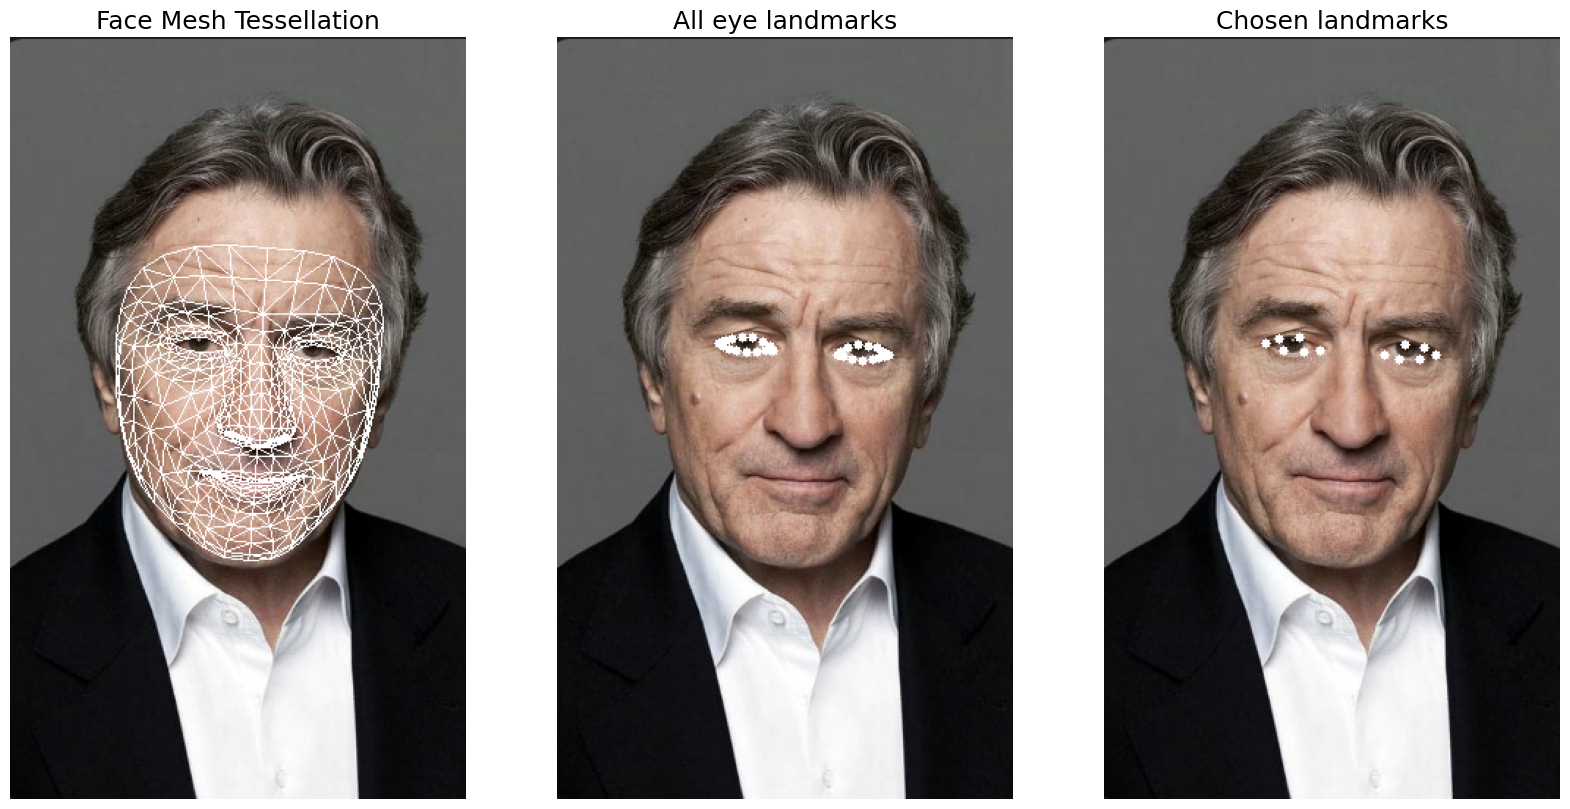

In [13]:

# If detections are available.
if results.multi_face_landmarks:
     
    # Iterate over detections of each face. Here, we have max_num_faces=1, 
    # So there will be at most 1 element in 
    # the 'results.multi_face_landmarks' list            
    # Only one iteration is performed.
 
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        _ = plot(img_dt=image.copy(), face_landmarks=face_landmarks)

In [14]:
def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [15]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.
 
    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame
 
    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, 
                                             frame_width, frame_height)
            coords_points.append(coord)
 
        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

In [16]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    """Calculate Eye aspect ratio"""
 
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

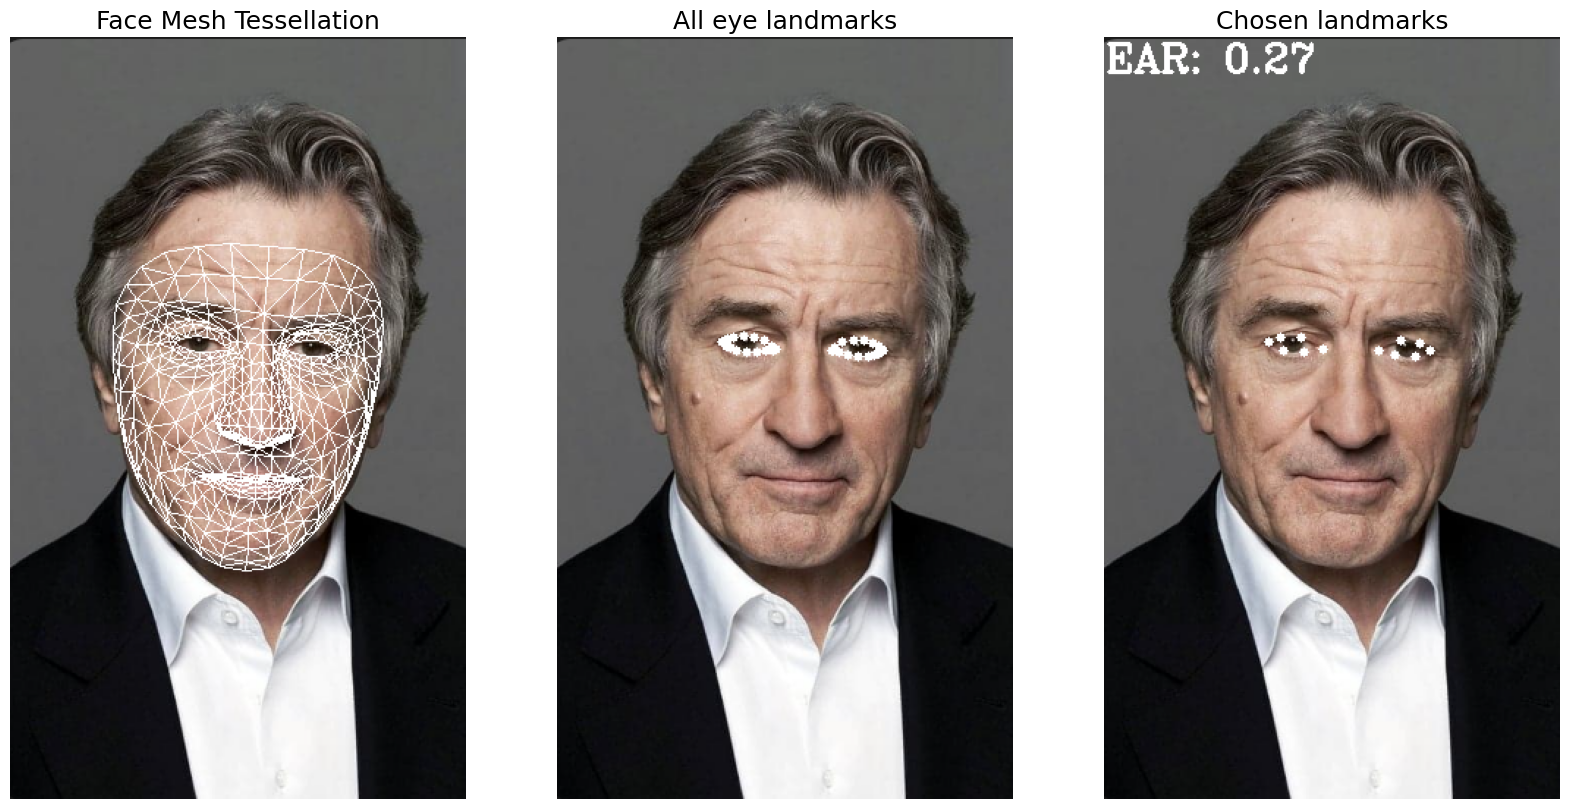

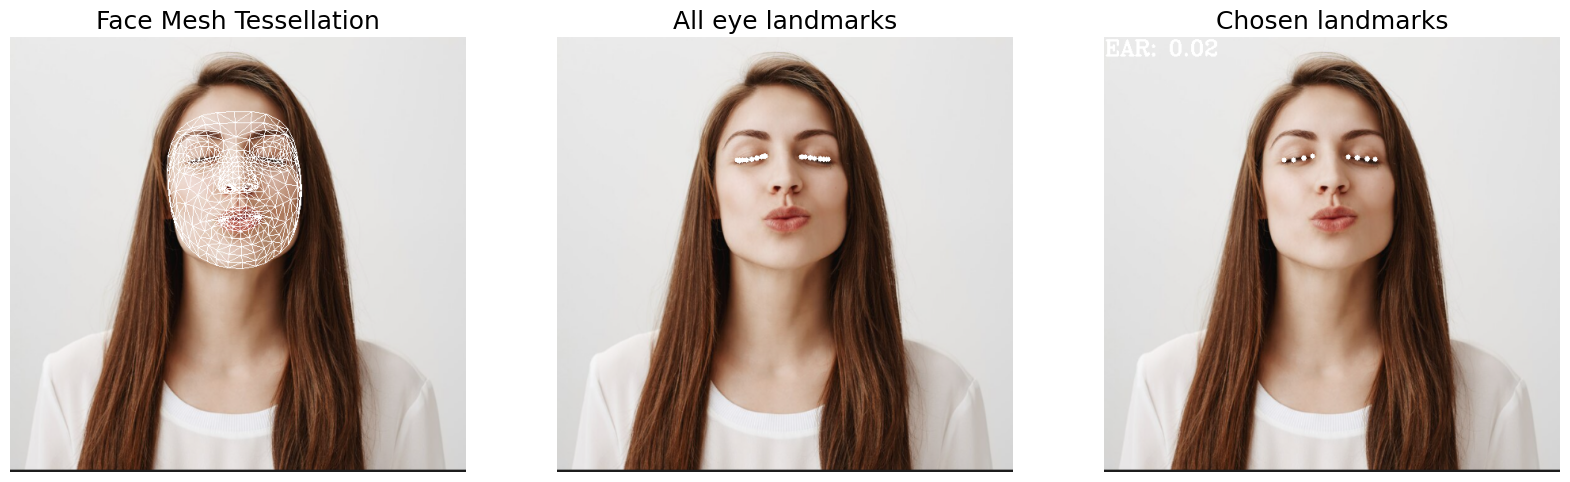

In [23]:
image_eyes_open  = cv2.imread("../fatigue_detection/images/test-open-eyes.jpg")[:, :, ::-1]
image_eyes_close = cv2.imread("../fatigue_detection/images/test-closed-eyes.jpg")[:, :, ::-1]
 
for idx, image in enumerate([image_eyes_open, image_eyes_close]):
    
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
 
    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()
 
    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
 
        # If detections are available.
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                      )
 
                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (255, 255, 255), 2
                )                
              
                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1, 
                     ts_circle_radius=3, 
                     lmk_circle_radius=3
                )